# Imports

In [65]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import pickle
import numpy as np
import sys
sys.path.append("../..")
from utils.diverse import *
from utils.data_transformations import *
from utils.visualization_tools import *
from sklearn.utils import resample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
set_random_state(42)

In [67]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Load dataset

In [68]:
with open("../../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

3030


In [69]:
dataset["sws"][slow_wave_ids[0]].keys()

dict_keys(['shape', 'hemo_aligned', 'gcamp_aligned', 'gcamp_interpolated', 'hemo_interpolated', 'correlation', 'width', 'height', 'start', 'stop', 'file_id', 'nc_start', 'nc_stop', 'left_too_high', 'iso', 'gcamp_mean_centered', 'flow_components', 'mean_sources', 'mean_sinks', 'gcamp_mean'])

# Load data for features, select slow waves

In [70]:
features = ["iso", "start", "stop", "width", "height", "gcamp_interpolated", "gcamp_mean", 
            "hemo_interpolated", "left_too_high", "correlation", "mean_sources", "mean_sinks"]
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features)

#Filter waves and get all data for filtered indices (where)
where = corr < .3
where[height/width < 0.1] = False
where[left_too_high] = False
#where[height/width < 0.05] = False

print(np.sum(where))
    
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features, where)

../../utils/diverse.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  feature = np.array([dataset["sws"][k][name] for k in slow_wave_ids])


205


In [71]:
sources_sinks = [np.hstack([a, b]) for a,b in zip(mean_sources, mean_sinks)]

Text(0, 0.5, 'Absolute frequency')

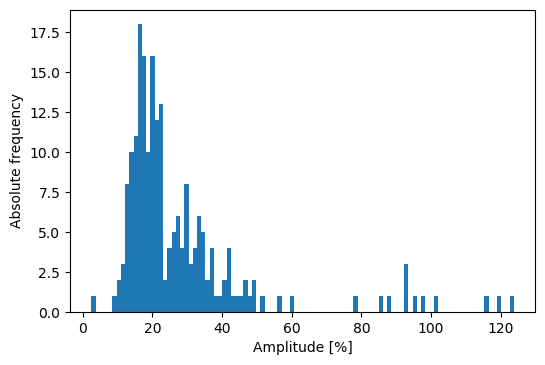

In [72]:
fig, ax = plt.subplots(1, dpi = 100)
_ = ax.hist(height, bins = 100)
ax.set_xlabel("Amplitude [%]")
ax.set_ylabel("Absolute frequency")

In [73]:
components = [dataset["sws"][id]["flow_components"]["per_wave"]["left_hemisphere"] for id in np.array(slow_wave_ids)[where]]
components = np.array(components)
relative_components = np.array([normalize(c) for c in components])
vertical_greater_horizontal = np.array([normalize(c) for c in components[:,1:3]])

In [74]:
abs_up_flow = np.abs(components[:,2])
abs_down_flow = np.abs(components[:,3])
abs_left_flow = np.abs(components[:,0])
abs_right_flow = np.abs(components[:,1])

ud = abs_up_flow + abs_down_flow
lr = abs_right_flow + abs_left_flow
up_flow = abs_up_flow/ud#upwards flow as fraction of total upwards/downwards flow
left_flow = abs_left_flow/lr#upwards flow as fraction of total upwards/downwards flow

flow_per_auc = (ud+lr)/[np.nansum(x) for x in gcamp_mean]

ratio_vertical_horizontal = ud/(ud+lr)

# Flow in a direction as percent of total flow

In [75]:
total_flow = (abs_left_flow+abs_right_flow+abs_up_flow+abs_down_flow)
leftwards_by_tot = (abs_left_flow)/total_flow
rightwards_by_tot = (abs_right_flow)/total_flow
upwards_by_tot = (abs_up_flow)/total_flow
downwards_by_tot = (abs_down_flow)/total_flow

flow_by_tot = [leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot]

In [76]:
components[0]

array([0.0028429 , 0.00197521, 0.00017828, 0.00095401], dtype=float32)

In [77]:
import pandas as pd
crosscorr = np.corrcoef([leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot])
df = pd.DataFrame(crosscorr, columns = ["Left","right", "up", "down"])
df.insert(0, column = "", value = ["Left","right", "up", "down"])
df

,,Left,right,up,down
0,Left,1.000000,0.604078,-0.069588,-0.749162
1,right,0.604078,1.000000,-0.075030,-0.740856
2,up,-0.069588,-0.075030,1.000000,-0.485936
3,down,-0.749162,-0.740856,-0.485936,1.000000


In [79]:
#abs_up_flow - abs_down_flow

In [80]:
#for uf in [up_flow[iso == i] for i in list(set(isos))]:
#    plt.scatter(np.arange(len(uf)), uf)
#    plt.plot([0,60], [np.mean(uf), np.mean(uf)])

## Prepare data

Use train test split to split the dataset. 

Append features that we aim to plot later such that they are split and shuffled in the same way.

In [81]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size=.25

In [78]:
components = (components.T / np.max(components, axis = 1)).T

In [82]:
values = np.hstack([np.array([width]).T, np.array([height]).T])
values = normalize(values)

In [83]:
values = np.hstack([values,np.array(flow_by_tot).T])

In [84]:
sources_sinks_train, sources_sinks_test = train_test_split(sources_sinks, test_size=test_size, random_state = random_state)
vectors_train, vectors_test = train_test_split(gcamp, test_size=test_size, random_state = random_state)
values_train, values_test = train_test_split(values, test_size=test_size, random_state = random_state)

sources_sinks_train =  np.expand_dims(sources_sinks_train,-1)
sources_sinks_test =  np.expand_dims(sources_sinks_test,-1)
vectors_train = np.expand_dims(vectors_train,-1)
vectors_test = np.expand_dims(vectors_test, -1)

vectors_train = np.expand_dims(vectors_train,1)
vectors_test = np.expand_dims(vectors_test, -1)

Save additional features as variables.

In [85]:
additional_features = [iso, corr, width, height, ratio_vertical_horizontal, up_flow, left_flow, flow_per_auc]
additional_features = [train_test_split(f, test_size=test_size, random_state = random_state) for f in additional_features]
add_train = [f[0] for f in additional_features]
add_test = [f[1] for f in additional_features]
iso_train, corr_train, width_train, height_train, ratio_vertical_horizontal_train, up_flow_train, left_flow_train, flow_per_auc_train = add_train
iso_test, corr_test, width_test, height_test, ratio_vertical_horizontal_test, up_flow_test, left_flow_test, flow_per_auc_test = add_test

In [86]:
print("There are " + str(len(iso_test)) + " test samples")

There are 52 test samples


In [87]:
print("The maximal amplitude of the percentage change in time is " 
              + str(np.max(height_train).round()))

The maximal amplitude of the percentage change in time is 124.0


# Variational Autoenconder

In [88]:
## network parameters
from predictive_modeling.models.vae_cnn_v2 import *
from keras import Model

batch_size = 100
epochs = 200

n_values = 6

In [89]:
[image_input, value_input, vector_input], [z_mean, z_log_var, z] = encoder(n_values)
latent_inputs, [image_decoded, values_decoded, vector_decoded] = decoder(n_values)

../../predictive_modeling/models/vae_cnn_v2.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=[64, 128, ..., activation="relu", strides=(4, 4))`
  image_model.add(Conv2D(32, (8, 8), subsample=(4, 4), input_shape=[64, 128,1], activation = "relu"))
../../predictive_modeling/models/vae_cnn_v2.py:114: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
  image_model.add(Conv2D(64, (4, 4), subsample=(2, 2), activation = "relu"))
../../predictive_modeling/models/vae_cnn_v2.py:115: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", strides=(1, 1))`
  image_model.add(Conv2D(64, (3, 3), subsample=(1, 1), activation = "relu"))


(None, 1, 128, 1)


In [90]:
encoder_model = Model(inputs = [image_input, value_input, vector_input], outputs = [z_mean, z_log_var, z])
decoder_model = Model(inputs = latent_inputs, outputs = [image_decoded, values_decoded, vector_decoded], name='decoder')

In [91]:
image_decoded, values_decoded, vector_decoded = decoder_model(encoder_model([image_input, value_input, vector_input])[2])

In [92]:
vae = Model(inputs = [image_input, value_input, vector_input], 
            outputs = [image_decoded, values_decoded, vector_decoded], name='vae_mlp')

In [93]:
print("The input shapes of the autoencoder are: ")
print(image_input.shape)
print(value_input.shape)
print(vector_input.shape)

The input shapes of the autoencoder are: 
(None, 64, 128, 1)
(None, 6)
(None, 1, 128, 1)


In [94]:
import keras
loss, loss_width_height, loss_signal_in_time, img_reconstruction_loss, loss_dirs = get_vae_loss(image_input, value_input, vector_input, image_decoded, values_decoded, vector_decoded, z_mean, z_log_var, impact_reconstruction_loss = 100)
vae.add_loss(loss)
vae.add_metric(loss_width_height, name='loss_width_height')
vae.add_metric(loss_dirs, name='loss_dirs')
vae.add_metric(loss_signal_in_time, name='loss_signal_in_time')
vae.add_metric(img_reconstruction_loss, name='img_reconstruction_loss')

vae.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01))
vae.compile(optimizer = "adam")

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [95]:
x_train_combined = [sources_sinks_train, values_train, vectors_train]

In [96]:
# train the autoencoder
history = vae.fit(x_train_combined, epochs= 1000, batch_size=batch_size, verbose=2)

Epoch 1/1000
 - 12s - loss: 448.9702 - loss_width_height: 0.0973 - loss_dirs: 0.0897 - loss_signal_in_time: 0.1243 - img_reconstruction_loss: 0.1188
Epoch 2/1000
 - 1s - loss: 502.2964 - loss_width_height: 0.0892 - loss_dirs: 0.0821 - loss_signal_in_time: 0.1214 - img_reconstruction_loss: 0.2711
Epoch 3/1000
 - 1s - loss: 396.1348 - loss_width_height: 0.0562 - loss_dirs: 0.0788 - loss_signal_in_time: 0.1218 - img_reconstruction_loss: 0.0837
Epoch 4/1000
 - 1s - loss: 393.3179 - loss_width_height: 0.0647 - loss_dirs: 0.0775 - loss_signal_in_time: 0.1197 - img_reconstruction_loss: 0.1008
Epoch 5/1000
 - 3s - loss: 385.2152 - loss_width_height: 0.0575 - loss_dirs: 0.0756 - loss_signal_in_time: 0.1193 - img_reconstruction_loss: 0.1055
Epoch 6/1000
 - 3s - loss: 371.3345 - loss_width_height: 0.0557 - loss_dirs: 0.0706 - loss_signal_in_time: 0.1163 - img_reconstruction_loss: 0.1029
Epoch 7/1000
 - 3s - loss: 350.8008 - loss_width_height: 0.0451 - loss_dirs: 0.0667 - loss_signal_in_time: 0.11

 - 1s - loss: 175.9737 - loss_width_height: 0.0202 - loss_dirs: 0.0508 - loss_signal_in_time: 0.0506 - img_reconstruction_loss: 0.0395
Epoch 57/1000
 - 1s - loss: 175.3754 - loss_width_height: 0.0196 - loss_dirs: 0.0506 - loss_signal_in_time: 0.0501 - img_reconstruction_loss: 0.0396
Epoch 58/1000
 - 1s - loss: 173.8558 - loss_width_height: 0.0190 - loss_dirs: 0.0500 - loss_signal_in_time: 0.0498 - img_reconstruction_loss: 0.0395
Epoch 59/1000
 - 1s - loss: 172.7131 - loss_width_height: 0.0215 - loss_dirs: 0.0492 - loss_signal_in_time: 0.0501 - img_reconstruction_loss: 0.0385
Epoch 60/1000
 - 1s - loss: 171.4316 - loss_width_height: 0.0201 - loss_dirs: 0.0481 - loss_signal_in_time: 0.0487 - img_reconstruction_loss: 0.0382
Epoch 61/1000
 - 1s - loss: 168.9816 - loss_width_height: 0.0193 - loss_dirs: 0.0470 - loss_signal_in_time: 0.0481 - img_reconstruction_loss: 0.0369
Epoch 62/1000
 - 1s - loss: 166.6055 - loss_width_height: 0.0178 - loss_dirs: 0.0466 - loss_signal_in_time: 0.0487 - img

 - 1s - loss: 101.5077 - loss_width_height: 0.0079 - loss_dirs: 0.0409 - loss_signal_in_time: 0.0228 - img_reconstruction_loss: 0.0317
Epoch 112/1000
 - 1s - loss: 100.2947 - loss_width_height: 0.0074 - loss_dirs: 0.0397 - loss_signal_in_time: 0.0222 - img_reconstruction_loss: 0.0303
Epoch 113/1000
 - 1s - loss: 100.2634 - loss_width_height: 0.0081 - loss_dirs: 0.0408 - loss_signal_in_time: 0.0223 - img_reconstruction_loss: 0.0316
Epoch 114/1000
 - 1s - loss: 99.9432 - loss_width_height: 0.0071 - loss_dirs: 0.0405 - loss_signal_in_time: 0.0216 - img_reconstruction_loss: 0.0306
Epoch 115/1000
 - 1s - loss: 99.2539 - loss_width_height: 0.0084 - loss_dirs: 0.0396 - loss_signal_in_time: 0.0220 - img_reconstruction_loss: 0.0316
Epoch 116/1000
 - 1s - loss: 99.2329 - loss_width_height: 0.0078 - loss_dirs: 0.0400 - loss_signal_in_time: 0.0211 - img_reconstruction_loss: 0.0316
Epoch 117/1000
 - 1s - loss: 98.4592 - loss_width_height: 0.0084 - loss_dirs: 0.0401 - loss_signal_in_time: 0.0214 - i

 - 1s - loss: 83.0746 - loss_width_height: 0.0031 - loss_dirs: 0.0404 - loss_signal_in_time: 0.0152 - img_reconstruction_loss: 0.0294
Epoch 167/1000
 - 1s - loss: 83.1743 - loss_width_height: 0.0030 - loss_dirs: 0.0409 - loss_signal_in_time: 0.0152 - img_reconstruction_loss: 0.0296
Epoch 168/1000
 - 1s - loss: 83.2798 - loss_width_height: 0.0038 - loss_dirs: 0.0411 - loss_signal_in_time: 0.0157 - img_reconstruction_loss: 0.0298
Epoch 169/1000
 - 1s - loss: 82.8424 - loss_width_height: 0.0034 - loss_dirs: 0.0413 - loss_signal_in_time: 0.0158 - img_reconstruction_loss: 0.0294
Epoch 170/1000
 - 1s - loss: 81.7880 - loss_width_height: 0.0031 - loss_dirs: 0.0404 - loss_signal_in_time: 0.0147 - img_reconstruction_loss: 0.0291
Epoch 171/1000
 - 1s - loss: 81.8818 - loss_width_height: 0.0032 - loss_dirs: 0.0413 - loss_signal_in_time: 0.0152 - img_reconstruction_loss: 0.0284
Epoch 172/1000
 - 1s - loss: 82.0364 - loss_width_height: 0.0029 - loss_dirs: 0.0415 - loss_signal_in_time: 0.0153 - img_

 - 1s - loss: 73.3715 - loss_width_height: 0.0026 - loss_dirs: 0.0394 - loss_signal_in_time: 0.0119 - img_reconstruction_loss: 0.0280
Epoch 222/1000
 - 1s - loss: 73.0113 - loss_width_height: 0.0025 - loss_dirs: 0.0398 - loss_signal_in_time: 0.0109 - img_reconstruction_loss: 0.0283
Epoch 223/1000
 - 1s - loss: 72.8109 - loss_width_height: 0.0027 - loss_dirs: 0.0387 - loss_signal_in_time: 0.0117 - img_reconstruction_loss: 0.0284
Epoch 224/1000
 - 1s - loss: 73.3159 - loss_width_height: 0.0026 - loss_dirs: 0.0395 - loss_signal_in_time: 0.0114 - img_reconstruction_loss: 0.0278
Epoch 225/1000
 - 1s - loss: 72.8504 - loss_width_height: 0.0030 - loss_dirs: 0.0397 - loss_signal_in_time: 0.0113 - img_reconstruction_loss: 0.0286
Epoch 226/1000
 - 1s - loss: 72.4372 - loss_width_height: 0.0029 - loss_dirs: 0.0392 - loss_signal_in_time: 0.0114 - img_reconstruction_loss: 0.0282
Epoch 227/1000
 - 1s - loss: 72.1989 - loss_width_height: 0.0028 - loss_dirs: 0.0387 - loss_signal_in_time: 0.0114 - img_

 - 1s - loss: 68.8905 - loss_width_height: 0.0024 - loss_dirs: 0.0384 - loss_signal_in_time: 0.0103 - img_reconstruction_loss: 0.0273
Epoch 277/1000
 - 1s - loss: 69.1563 - loss_width_height: 0.0022 - loss_dirs: 0.0380 - loss_signal_in_time: 0.0104 - img_reconstruction_loss: 0.0267
Epoch 278/1000
 - 1s - loss: 68.7838 - loss_width_height: 0.0024 - loss_dirs: 0.0374 - loss_signal_in_time: 0.0105 - img_reconstruction_loss: 0.0260
Epoch 279/1000
 - 1s - loss: 68.5733 - loss_width_height: 0.0022 - loss_dirs: 0.0377 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0265
Epoch 280/1000
 - 1s - loss: 69.3932 - loss_width_height: 0.0022 - loss_dirs: 0.0385 - loss_signal_in_time: 0.0105 - img_reconstruction_loss: 0.0269
Epoch 281/1000
 - 1s - loss: 69.9262 - loss_width_height: 0.0026 - loss_dirs: 0.0382 - loss_signal_in_time: 0.0107 - img_reconstruction_loss: 0.0272
Epoch 282/1000
 - 1s - loss: 70.6013 - loss_width_height: 0.0028 - loss_dirs: 0.0385 - loss_signal_in_time: 0.0103 - img_

 - 1s - loss: 66.6013 - loss_width_height: 0.0024 - loss_dirs: 0.0371 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0256
Epoch 332/1000
 - 1s - loss: 66.2609 - loss_width_height: 0.0018 - loss_dirs: 0.0379 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0259
Epoch 333/1000
 - 1s - loss: 66.1045 - loss_width_height: 0.0019 - loss_dirs: 0.0374 - loss_signal_in_time: 0.0093 - img_reconstruction_loss: 0.0253
Epoch 334/1000
 - 1s - loss: 66.4430 - loss_width_height: 0.0026 - loss_dirs: 0.0386 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0258
Epoch 335/1000
 - 1s - loss: 66.1917 - loss_width_height: 0.0023 - loss_dirs: 0.0383 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0255
Epoch 336/1000
 - 1s - loss: 66.3660 - loss_width_height: 0.0019 - loss_dirs: 0.0368 - loss_signal_in_time: 0.0091 - img_reconstruction_loss: 0.0256
Epoch 337/1000
 - 1s - loss: 66.3611 - loss_width_height: 0.0020 - loss_dirs: 0.0372 - loss_signal_in_time: 0.0091 - img_

 - 1s - loss: 65.4951 - loss_width_height: 0.0017 - loss_dirs: 0.0378 - loss_signal_in_time: 0.0090 - img_reconstruction_loss: 0.0248
Epoch 387/1000
 - 1s - loss: 65.6790 - loss_width_height: 0.0021 - loss_dirs: 0.0369 - loss_signal_in_time: 0.0092 - img_reconstruction_loss: 0.0248
Epoch 388/1000
 - 1s - loss: 66.7392 - loss_width_height: 0.0021 - loss_dirs: 0.0363 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0256
Epoch 389/1000
 - 1s - loss: 67.2532 - loss_width_height: 0.0024 - loss_dirs: 0.0365 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0257
Epoch 390/1000
 - 1s - loss: 66.2688 - loss_width_height: 0.0018 - loss_dirs: 0.0375 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0250
Epoch 391/1000
 - 1s - loss: 66.2078 - loss_width_height: 0.0023 - loss_dirs: 0.0381 - loss_signal_in_time: 0.0096 - img_reconstruction_loss: 0.0263
Epoch 392/1000
 - 1s - loss: 66.3863 - loss_width_height: 0.0021 - loss_dirs: 0.0372 - loss_signal_in_time: 0.0092 - img_

 - 1s - loss: 63.7844 - loss_width_height: 0.0017 - loss_dirs: 0.0364 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0244
Epoch 442/1000
 - 1s - loss: 63.5339 - loss_width_height: 0.0019 - loss_dirs: 0.0363 - loss_signal_in_time: 0.0086 - img_reconstruction_loss: 0.0239
Epoch 443/1000
 - 1s - loss: 63.2457 - loss_width_height: 0.0016 - loss_dirs: 0.0372 - loss_signal_in_time: 0.0086 - img_reconstruction_loss: 0.0245
Epoch 444/1000
 - 1s - loss: 63.9399 - loss_width_height: 0.0017 - loss_dirs: 0.0378 - loss_signal_in_time: 0.0088 - img_reconstruction_loss: 0.0242
Epoch 445/1000
 - 1s - loss: 64.1871 - loss_width_height: 0.0016 - loss_dirs: 0.0364 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0242
Epoch 446/1000
 - 1s - loss: 63.5796 - loss_width_height: 0.0020 - loss_dirs: 0.0370 - loss_signal_in_time: 0.0086 - img_reconstruction_loss: 0.0238
Epoch 447/1000
 - 1s - loss: 63.5476 - loss_width_height: 0.0018 - loss_dirs: 0.0369 - loss_signal_in_time: 0.0084 - img_

 - 1s - loss: 62.4846 - loss_width_height: 0.0014 - loss_dirs: 0.0360 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0231
Epoch 497/1000
 - 1s - loss: 62.6311 - loss_width_height: 0.0015 - loss_dirs: 0.0368 - loss_signal_in_time: 0.0081 - img_reconstruction_loss: 0.0238
Epoch 498/1000
 - 1s - loss: 62.4469 - loss_width_height: 0.0015 - loss_dirs: 0.0364 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0230
Epoch 499/1000
 - 1s - loss: 62.0678 - loss_width_height: 0.0014 - loss_dirs: 0.0354 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0224
Epoch 500/1000
 - 1s - loss: 62.6071 - loss_width_height: 0.0017 - loss_dirs: 0.0360 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0225
Epoch 501/1000
 - 1s - loss: 62.5684 - loss_width_height: 0.0018 - loss_dirs: 0.0371 - loss_signal_in_time: 0.0084 - img_reconstruction_loss: 0.0229
Epoch 502/1000
 - 1s - loss: 62.4685 - loss_width_height: 0.0013 - loss_dirs: 0.0369 - loss_signal_in_time: 0.0080 - img_

 - 1s - loss: 62.2949 - loss_width_height: 0.0012 - loss_dirs: 0.0364 - loss_signal_in_time: 0.0077 - img_reconstruction_loss: 0.0226
Epoch 552/1000
 - 1s - loss: 63.2392 - loss_width_height: 0.0025 - loss_dirs: 0.0363 - loss_signal_in_time: 0.0082 - img_reconstruction_loss: 0.0227
Epoch 553/1000
 - 1s - loss: 63.1586 - loss_width_height: 0.0021 - loss_dirs: 0.0373 - loss_signal_in_time: 0.0081 - img_reconstruction_loss: 0.0226
Epoch 554/1000
 - 1s - loss: 62.7841 - loss_width_height: 0.0020 - loss_dirs: 0.0357 - loss_signal_in_time: 0.0080 - img_reconstruction_loss: 0.0223
Epoch 555/1000
 - 1s - loss: 63.0232 - loss_width_height: 0.0018 - loss_dirs: 0.0368 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0231
Epoch 556/1000
 - 1s - loss: 62.4955 - loss_width_height: 0.0014 - loss_dirs: 0.0370 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0228
Epoch 557/1000
 - 1s - loss: 62.6695 - loss_width_height: 0.0020 - loss_dirs: 0.0369 - loss_signal_in_time: 0.0078 - img_

 - 1s - loss: 63.1286 - loss_width_height: 0.0021 - loss_dirs: 0.0358 - loss_signal_in_time: 0.0082 - img_reconstruction_loss: 0.0227
Epoch 607/1000
 - 1s - loss: 62.5032 - loss_width_height: 0.0017 - loss_dirs: 0.0363 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0227
Epoch 608/1000
 - 1s - loss: 61.4755 - loss_width_height: 0.0012 - loss_dirs: 0.0361 - loss_signal_in_time: 0.0076 - img_reconstruction_loss: 0.0212
Epoch 609/1000
 - 1s - loss: 60.8102 - loss_width_height: 0.0015 - loss_dirs: 0.0363 - loss_signal_in_time: 0.0077 - img_reconstruction_loss: 0.0220
Epoch 610/1000
 - 1s - loss: 60.7852 - loss_width_height: 0.0012 - loss_dirs: 0.0362 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0219
Epoch 611/1000
 - 1s - loss: 60.7205 - loss_width_height: 0.0014 - loss_dirs: 0.0374 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0228
Epoch 612/1000
 - 1s - loss: 61.1910 - loss_width_height: 0.0013 - loss_dirs: 0.0364 - loss_signal_in_time: 0.0076 - img_

Epoch 661/1000
 - 1s - loss: 60.5536 - loss_width_height: 9.8193e-04 - loss_dirs: 0.0363 - loss_signal_in_time: 0.0072 - img_reconstruction_loss: 0.0208
Epoch 662/1000
 - 1s - loss: 60.2838 - loss_width_height: 0.0011 - loss_dirs: 0.0354 - loss_signal_in_time: 0.0075 - img_reconstruction_loss: 0.0212
Epoch 663/1000
 - 1s - loss: 60.8700 - loss_width_height: 0.0012 - loss_dirs: 0.0355 - loss_signal_in_time: 0.0077 - img_reconstruction_loss: 0.0221
Epoch 664/1000
 - 1s - loss: 61.4270 - loss_width_height: 0.0012 - loss_dirs: 0.0358 - loss_signal_in_time: 0.0079 - img_reconstruction_loss: 0.0225
Epoch 665/1000
 - 1s - loss: 61.9724 - loss_width_height: 0.0017 - loss_dirs: 0.0351 - loss_signal_in_time: 0.0086 - img_reconstruction_loss: 0.0215
Epoch 666/1000
 - 1s - loss: 61.6280 - loss_width_height: 0.0016 - loss_dirs: 0.0360 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0222
Epoch 667/1000
 - 1s - loss: 61.2495 - loss_width_height: 0.0014 - loss_dirs: 0.0356 - loss_signal_in_

Epoch 716/1000
 - 1s - loss: 59.5078 - loss_width_height: 0.0010 - loss_dirs: 0.0360 - loss_signal_in_time: 0.0073 - img_reconstruction_loss: 0.0207
Epoch 717/1000
 - 1s - loss: 59.8920 - loss_width_height: 0.0012 - loss_dirs: 0.0350 - loss_signal_in_time: 0.0072 - img_reconstruction_loss: 0.0205
Epoch 718/1000
 - 1s - loss: 59.3820 - loss_width_height: 0.0012 - loss_dirs: 0.0356 - loss_signal_in_time: 0.0072 - img_reconstruction_loss: 0.0203
Epoch 719/1000
 - 1s - loss: 59.3200 - loss_width_height: 0.0012 - loss_dirs: 0.0357 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0207
Epoch 720/1000
 - 1s - loss: 59.2983 - loss_width_height: 9.6483e-04 - loss_dirs: 0.0374 - loss_signal_in_time: 0.0073 - img_reconstruction_loss: 0.0206
Epoch 721/1000
 - 1s - loss: 59.7897 - loss_width_height: 0.0011 - loss_dirs: 0.0362 - loss_signal_in_time: 0.0072 - img_reconstruction_loss: 0.0212
Epoch 722/1000
 - 1s - loss: 59.4491 - loss_width_height: 0.0011 - loss_dirs: 0.0362 - loss_signal_in_

Epoch 771/1000
 - 1s - loss: 58.7749 - loss_width_height: 9.3749e-04 - loss_dirs: 0.0352 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0203
Epoch 772/1000
 - 1s - loss: 58.7998 - loss_width_height: 0.0010 - loss_dirs: 0.0360 - loss_signal_in_time: 0.0072 - img_reconstruction_loss: 0.0209
Epoch 773/1000
 - 1s - loss: 58.8702 - loss_width_height: 0.0010 - loss_dirs: 0.0357 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0200
Epoch 774/1000
 - 1s - loss: 59.4237 - loss_width_height: 0.0011 - loss_dirs: 0.0362 - loss_signal_in_time: 0.0073 - img_reconstruction_loss: 0.0204
Epoch 775/1000
 - 1s - loss: 59.9430 - loss_width_height: 0.0015 - loss_dirs: 0.0357 - loss_signal_in_time: 0.0072 - img_reconstruction_loss: 0.0204
Epoch 776/1000
 - 1s - loss: 59.4689 - loss_width_height: 0.0015 - loss_dirs: 0.0368 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0205
Epoch 777/1000
 - 1s - loss: 59.5404 - loss_width_height: 0.0017 - loss_dirs: 0.0363 - loss_signal_in_

Epoch 826/1000
 - 1s - loss: 58.4508 - loss_width_height: 9.6724e-04 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0191
Epoch 827/1000
 - 1s - loss: 58.1634 - loss_width_height: 8.6510e-04 - loss_dirs: 0.0354 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0194
Epoch 828/1000
 - 1s - loss: 57.9583 - loss_width_height: 8.8577e-04 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0066 - img_reconstruction_loss: 0.0194
Epoch 829/1000
 - 1s - loss: 58.3841 - loss_width_height: 9.6160e-04 - loss_dirs: 0.0362 - loss_signal_in_time: 0.0067 - img_reconstruction_loss: 0.0201
Epoch 830/1000
 - 1s - loss: 58.5981 - loss_width_height: 8.7854e-04 - loss_dirs: 0.0358 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0197
Epoch 831/1000
 - 1s - loss: 58.6335 - loss_width_height: 9.4919e-04 - loss_dirs: 0.0362 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0196
Epoch 832/1000
 - 1s - loss: 58.5985 - loss_width_height: 8.8607e-04 - loss_dirs: 

Epoch 880/1000
 - 1s - loss: 57.9686 - loss_width_height: 0.0012 - loss_dirs: 0.0359 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0202
Epoch 881/1000
 - 1s - loss: 57.5936 - loss_width_height: 8.7452e-04 - loss_dirs: 0.0352 - loss_signal_in_time: 0.0064 - img_reconstruction_loss: 0.0198
Epoch 882/1000
 - 1s - loss: 57.4091 - loss_width_height: 8.6301e-04 - loss_dirs: 0.0354 - loss_signal_in_time: 0.0063 - img_reconstruction_loss: 0.0190
Epoch 883/1000
 - 1s - loss: 57.4363 - loss_width_height: 8.8433e-04 - loss_dirs: 0.0354 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0185
Epoch 884/1000
 - 1s - loss: 57.5792 - loss_width_height: 7.7148e-04 - loss_dirs: 0.0358 - loss_signal_in_time: 0.0066 - img_reconstruction_loss: 0.0190
Epoch 885/1000
 - 1s - loss: 57.4386 - loss_width_height: 7.2369e-04 - loss_dirs: 0.0357 - loss_signal_in_time: 0.0066 - img_reconstruction_loss: 0.0186
Epoch 886/1000
 - 1s - loss: 57.4200 - loss_width_height: 7.2598e-04 - loss_dirs: 0.03

Epoch 934/1000
 - 1s - loss: 57.7182 - loss_width_height: 8.7918e-04 - loss_dirs: 0.0350 - loss_signal_in_time: 0.0064 - img_reconstruction_loss: 0.0186
Epoch 935/1000
 - 1s - loss: 57.8644 - loss_width_height: 0.0010 - loss_dirs: 0.0349 - loss_signal_in_time: 0.0066 - img_reconstruction_loss: 0.0192
Epoch 936/1000
 - 1s - loss: 57.3293 - loss_width_height: 7.8144e-04 - loss_dirs: 0.0350 - loss_signal_in_time: 0.0064 - img_reconstruction_loss: 0.0181
Epoch 937/1000
 - 1s - loss: 57.3206 - loss_width_height: 7.6092e-04 - loss_dirs: 0.0340 - loss_signal_in_time: 0.0063 - img_reconstruction_loss: 0.0182
Epoch 938/1000
 - 1s - loss: 57.8219 - loss_width_height: 8.1085e-04 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0064 - img_reconstruction_loss: 0.0176
Epoch 939/1000
 - 1s - loss: 57.6407 - loss_width_height: 8.2549e-04 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0067 - img_reconstruction_loss: 0.0184
Epoch 940/1000
 - 1s - loss: 57.5816 - loss_width_height: 0.0011 - loss_dirs: 0.0354 -

Epoch 988/1000
 - 1s - loss: 57.3533 - loss_width_height: 8.2324e-04 - loss_dirs: 0.0359 - loss_signal_in_time: 0.0066 - img_reconstruction_loss: 0.0182
Epoch 989/1000
 - 1s - loss: 57.6062 - loss_width_height: 9.1421e-04 - loss_dirs: 0.0343 - loss_signal_in_time: 0.0068 - img_reconstruction_loss: 0.0178
Epoch 990/1000
 - 1s - loss: 57.0463 - loss_width_height: 9.2904e-04 - loss_dirs: 0.0353 - loss_signal_in_time: 0.0065 - img_reconstruction_loss: 0.0175
Epoch 991/1000
 - 1s - loss: 57.5311 - loss_width_height: 8.8668e-04 - loss_dirs: 0.0349 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0181
Epoch 992/1000
 - 1s - loss: 57.5631 - loss_width_height: 0.0011 - loss_dirs: 0.0361 - loss_signal_in_time: 0.0067 - img_reconstruction_loss: 0.0181
Epoch 993/1000
 - 1s - loss: 57.2623 - loss_width_height: 0.0010 - loss_dirs: 0.0349 - loss_signal_in_time: 0.0064 - img_reconstruction_loss: 0.0172
Epoch 994/1000
 - 1s - loss: 57.1831 - loss_width_height: 7.8293e-04 - loss_dirs: 0.0361 -

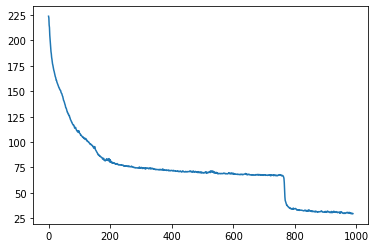

In [43]:
plt.plot(vae.history.history["loss"][10:])

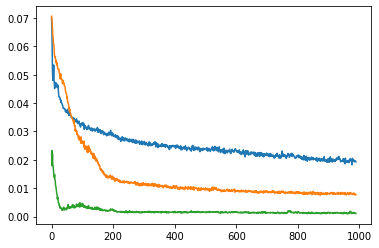

In [44]:
plt.plot(vae.history.history["img_reconstruction_loss"][10:])
plt.plot(vae.history.history["loss_signal_in_time"][10:])
plt.plot(vae.history.history["loss_width_height"][10:])
#plt.plot(vae.history.history["val_loss_direction"][10:])

# Visualize predictions

In [45]:
res = vae.predict(x_train_combined)

In [46]:
val_predictions = res[1]

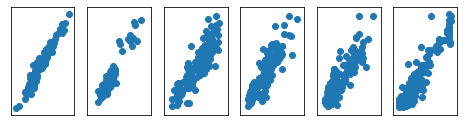

In [54]:
fig, ax = plt.subplots(1,6, figsize = (8,2))
for x in range(6):
    ax[x].scatter(val_predictions[:,0+x], values_train[:,0+x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])

In [55]:
from scipy.ndimage import median_filter

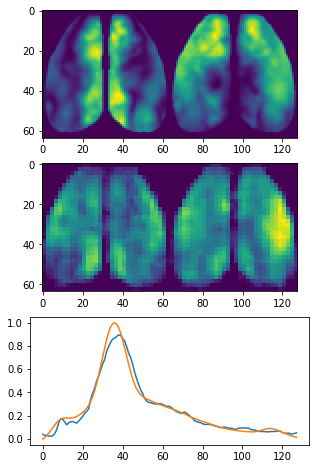

In [57]:
i = 3
fig, ax = plt.subplots(3, figsize= (5,8))
ax[0].imshow(sources_sinks_train[i][:,:,0])
ax[1].imshow(res[0][i][:,:,0])

ax[2].plot(res[2][i][0,:128,0])
ax[2].plot(vectors_train[i][0,:128,0])

In [58]:
from plots import manifold
from plots import manifold_of_images

In [59]:
#Predictions for z[0] and z[1] neurons i.e. x and y for the train and test datasets 
x_pred_train, y_pred_train = encoder_model.predict(x_train_combined)[2].T

In [60]:
%%capture
x_min = np.mean(x_pred_train)-2*np.std(x_pred_train)
y_min = np.mean(y_pred_train)-2*np.std(y_pred_train)
x_max = np.mean(x_pred_train)+2*np.std(x_pred_train)
y_max = np.mean(y_pred_train)+2*np.std(y_pred_train)
x_range = [x_min, x_max]
y_range = [y_min, y_max]

man_mean_signal = manifold(decoder_model, x_range, y_range, n = 15, dpi = 300, scale="sqrt", multi_output = True)

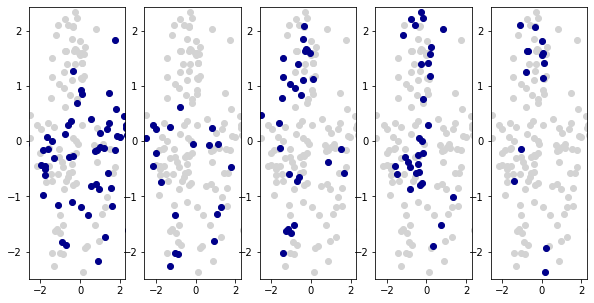

In [61]:
z_train = encoder_model.predict(x_train_combined)[2].T

fig, ax = plt.subplots(1,5, figsize= (10,5))
isos = [1.8, 2.0, 2.2, 2.4, 2.6]

def add_feature_plot(ax, iso):
    ax.scatter(*z_train, c= "lightgray")
    ax.scatter(*(z_train.T[iso_train == iso]).T, c = "darkblue")

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

for iso, a in zip(isos,ax):
    add_feature_plot(a, iso)

In [64]:
#%%capture
manifold_vector_components = manifold_of_vector_components(x_range = x_range, y_range = y_range, decoder_model = decoder_model, debug = True)

NameError: name 'manifold_of_vector_components' is not defined

In [63]:
sources_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sources")
sinks_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sinks")

In [ ]:
plt.plot(decoder_model.predict([[[2,2]]])[2][0,0,:,0])

In [ ]:
fig = plt.figure(constrained_layout = False, figsize = (10, 10), dpi = 500)
gs1 = fig.add_gridspec(nrows = 6, ncols = 4, left=0.05, right=0.48, wspace=0.05)
ax0 = fig.add_subplot(gs1[0:2, 0:2])
ax1 = fig.add_subplot(gs1[0:2, 2:4])
ax2 = fig.add_subplot(gs1[2:4, 0:2])
ax3 = fig.add_subplot(gs1[2:4, 2:4])
ax4 = fig.add_subplot(gs1[4:6, 0:2])
ax5 = fig.add_subplot(gs1[4:6, 2:4])

ax0.imshow(man_mean_signal)
ax1.imshow(manifold_vector_components)
ax2.imshow(man_mean_signal)
ax3.imshow(man_mean_signal)
ax4.imshow(sources_manifold)
ax5.imshow(sinks_manifold)

In [65]:
x_train.shape

(153, 130)

# Visualization

In [36]:
vae.save("full_vae")

In [41]:
vae = keras.models.load_model("full_vae", custom_objects={'tf': tf}, compile = False)